# Elections législatives 2024, 2e tour

## 1. Importations

### 1.1 Librarires

In [46]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import pltviz
import poli_sci_kit
import seaborn as sns
import json
import requests
from bs4 import BeautifulSoup
import math

### 1.2 Fichiers centraux

In [47]:
df = pd.read_excel('../data/resultats_circo_1er_tour_2024.xlsx')
print(df.columns)


Index(['Code département', 'Libellé département',
       'Code circonscription législative',
       'Libellé circonscription législative', 'Inscrits', 'Votants',
       '% Votants', 'Abstentions', '% Abstentions', 'Exprimés',
       ...
       'Elu 18', 'Numéro de panneau 19', 'Nuance candidat 19',
       'Nom candidat 19', 'Prénom candidat 19', 'Sexe candidat 19', 'Voix 19',
       '% Voix/inscrits 19', '% Voix/exprimés 19', 'Elu 19'],
      dtype='object', length=189)


## 2. Préparer un dataFrame pour le 2e tour

In [48]:
columns = [
    'Code département', 
    'Libellé département', 
    'Code circonscription législative',
    "Libellé circonscription législative",
    "Inscrits",
    "Votants",
    "% Votants",
    "Abstentions",
    "% Abstentions",
    "Exprimés",
    "% Exprimés/inscrits",
    "% Exprimés/votants",
    "Blancs",
    "% Blancs/inscrits",
    "% Blancs/votants",
    "Nuls",
    "% Nuls/inscrits",
    "% Nuls/votants",

    "Nuance candidat 1",
    "Nom candidat 1",
    "Prénom candidat 1", 
    "Sexe candidat 1",
    "Voix candidat 1",

    "Nuance candidat 2",
    "Nom candidat 2",
    "Prénom candidat 2",
    "Sexe candidat 2",
    "Voix candidat 2",

    "Nuance candidat 3",
    "Nom candidat 3",
    "Prénom candidat 3",
    "Sexe candidat 3",
    "Voix candidat 3",

    "nb_candidats",
    "Winner",
    "id_circ",
]

In [123]:
def second_tour_candidats_optimized(df_candidats, alliances, columns=columns):
    # Initialize an empty list for collecting custom rows
    rows = []
    def report_outre_mer(code):
        code = str(code)
        if code == "971":
            return "ZA"
        if code == "972":
            return "ZB"
        if code == "974":
            return "ZD"
        if code == "975":
            return "ZS"
        if code == "976":
            return "ZM"
        if code == "986":
            return "ZW"
        if code == "987":
            return "ZP"
        if code == "988":
            return "ZN"
        # if len(code) == 1:
        #     return code.zfill(2)
        return code
    
    for index, row in df_candidats.iterrows():
        # Create a custom row as a dictionary
        custom_row = {
            "Code département" : row["Code département"],
            "Libellé département" : row["Libellé département"],
            "Code circonscription législative" : row["Code circonscription législative"],
            "Libellé circonscription législative" : row["Libellé circonscription législative"],
            "Inscrits" : row["Inscrits"],
            "Votants" : row["Votants"],
            "% Votants" : row["% Votants"],
            "Abstentions" : row["Abstentions"],
            "% Abstentions" : row["% Abstentions"],
            "Exprimés" : row["Exprimés"],
            "% Exprimés/inscrits" : row["% Exprimés/inscrits"],
            "% Exprimés/votants" : row["% Exprimés/votants"],
            "Blancs" : row["Blancs"],
            "% Blancs/inscrits" : row["% Blancs/inscrits"],
            "% Blancs/votants" : row["% Blancs/votants"],
            "Nuls" : row["Nuls"],
            "% Nuls/inscrits" : row["% Nuls/inscrits"],
            "% Nuls/votants" : row["% Nuls/votants"],

            "Nuance candidat 1" : "",
            "Nom candidat 1" : "",
            "Prénom candidat 1" : "",
            "Sexe candidat 1" : "",
            "Voix candidat 1" : 0,

            "Nuance candidat 2" : "",
            "Nom candidat 2" : "",
            "Prénom candidat 2" : "",
            "Sexe candidat 2" : "",
            "Voix candidat 2" : 0,

            "Nuance candidat 3" : "",
            "Nom candidat 3" : "",
            "Prénom candidat 3" : "",
            "Sexe candidat 3" : "",
            "Voix candidat 3" : 0,

            "nb_candidats" : 0,
            "Winner" : "",
            "id_circ" : report_outre_mer(row["Code circonscription législative"][:-2]) +"0" + row["Code circonscription législative"][-2:],
        }
        def get_candidates_qualifies(row):
            candidate_indices = []
            candidate_data = []  # To store tuples of (index, voix_inscrits)

            for i in range(1, 20):
                # Assuming 'row' is defined elsewhere and contains the candidate data
                elu = row[f"Elu {i}"]
                voix_inscrits = row[f"% Voix/inscrits {i}"]

                try:
                    voix_inscrits = float(voix_inscrits.replace("%", "").replace(",", "."))
                except AttributeError:
                    # This block executes if the conversion fails, e.g., if voix_inscrits is "nan"
                    continue  
                # Check if the candidate is elected or has more than 12.5% of voix/inscrits
                if elu == "élu":
                    candidate_data.clear()
                    candidate_data.append((i, voix_inscrits))
                    break  # Assuming you want to stop the loop if an elected candidate is found
                elif voix_inscrits > 12.5:
                    candidate_data.append((i, voix_inscrits))
            if(len(candidate_data) == 0):
                max_voix = 0
                max_index = 0
                for i in range(1, 20):
                    voix_inscrits = row[f"% Voix/inscrits {i}"]
                    try:
                        voix_inscrits = float(voix_inscrits.replace("%", "").replace(",", "."))
                    except AttributeError:
                        # This block executes if the conversion fails, e.g., if voix_inscrits is "nan"
                        continue
                    if(voix_inscrits > max_voix):
                        max_voix = voix_inscrits
                        max_index = i
                return [max_index]

            # Sort candidates by voix_inscrits in descending order
            sorted_candidates = sorted(candidate_data, key=lambda x: x[1], reverse=True)

            # Extract sorted indices
            candidate_indices = [candidate[0] for candidate in sorted_candidates]

            return candidate_indices
        indexes = get_candidates_qualifies(row)
        ind = 1
        for i in indexes:
            if(ind == 4):
                continue
            custom_row[f"Nuance candidat {ind}"] = row[f"Nuance candidat {i}"]
            custom_row[f"Nom candidat {ind}"] = row[f"Nom candidat {i}"]
            custom_row[f"Prénom candidat {ind}"] = row[f"Prénom candidat {i}"]
            custom_row[f"Sexe candidat {ind}"] = row[f"Sexe candidat {i}"]
            custom_row[f"nb_candidats"] = ind
            ind+=1


        #Ensuite ici faut gérer les triangulaires.

        # La gauche se désiste si elle est 3e mdr
        if(alliances[custom_row["Nuance candidat 3"]] == "UG"):
            custom_row[f"Nuance candidat 3"] = ""
            custom_row[f"Nom candidat 3"] = ""
            custom_row[f"Prénom candidat 3"] = ""
            custom_row[f"Sexe candidat 3"] = ""
            custom_row[f"nb_candidats"] = 2
        
        # Macron se désiste quasiment jamais
        # if(alliances[custom_row["Nuance candidat 3"]] == "ENS"):
        #     custom_row[f"Nuance candidat 3"] = ""
        #     custom_row[f"Nom candidat 3"] = ""
        #     custom_row[f"Prénom candidat 3"] = ""
        #     custom_row[f"Sexe candidat 3"] = ""
        #     custom_row[f"nb_candidats"] = 2
        
        if(alliances[custom_row["Nuance candidat 3"]] == "RN" and alliances[custom_row["Nuance candidat 2"]] == "LR"):
            custom_row[f"Nuance candidat 3"] = ""
            custom_row[f"Nom candidat 3"] = ""
            custom_row[f"Prénom candidat 3"] = ""
            custom_row[f"Sexe candidat 3"] = ""
            custom_row[f"nb_candidats"] = 2
        
        rows.append(custom_row)
    
    # Convert the list of dictionaries to a DataFrame
    df_candidats_second = pd.DataFrame(rows, columns=columns)
    return df_candidats_second

In [124]:
def second_tour(df_candidats, df_second, alliances, matrice_report, index_report):
    for index, row in df_candidats.iterrows():
        row_second = df_second.iloc[index]
        parties = []
        for i in range(1, row_second["nb_candidats"] + 1):
            parties.append(row_second[f"Nuance candidat {i}"])
        if(len(parties) == 1):
            df_second.at[index, "Winner"] = parties[0]
            continue
        if(len(parties) == 0):
            df_second.at[index, "Winner"] = 0
            print("problème dans la " + str(index) + "e circo")
            continue
        for i in range(1, 20):
            party = row[f"Nuance candidat {i}"]
            if pd.isna(party) or party == "":
                continue
            alliance = alliances[party]
            voix = row[f"Voix {i}"]
            if alliance not in parties:
                # là il y a report des voix, et c'est le bordel
                # on va considérer que le 3e candidat dans une triangulaire se fait baiser
                parti_1 = index_report[alliances[row_second["Nuance candidat 1"]]]
                parti_2 = index_report[alliances[row_second["Nuance candidat 2"]]]
                report_1 = matrice_report[alliance][parti_1][parti_2]
                report_2 = matrice_report[alliance][parti_2][parti_1]

                # pour l'instant on fait du giga simplifié c plus facile
                df_second.at[index, "Voix candidat 1"] += round(voix * report_1)
                df_second.at[index, "Voix candidat 2"] += round(voix * report_2)
            else:
                df_second.at[index, f"Voix candidat {parties.index(alliance)+1}"] += voix
    return df_second           


In [125]:
alliances = {
    "EXG" : "EXG",
    "FI" : "UG",
    "UG" : "UG",
    "DVG" : "UG",
    "ECO" : "UG",
    "COM" : "UG",
    "SOC" : "UG",
    "RDG" : "UG",
    "ENS" : "ENS",
    "UDI" : "ENS",
    "DVC" : "ENS",
    "HOR" : "ENS",
    "LR" : "LR",
    "DVD" : "LR",
    "RN" : "RN",
    "UXD" : "RN",
    "DSV" : "RN",
    "EXD" : "EXD",
    "REC" : "EXD",
    "DIV" : "DIV",
    "REG" : "DIV",
    "VEC" : "DIV",
    "": "",
}

matrice_report = {
    "EXG" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
        [0.00, 0.50, 0.50, 0.80, 0.85, 0.90, 0.90, 0.90, 0.50],
        [0.00, 0.50, 0.50, 0.80, 0.85, 0.90, 0.90, 0.90, 0.50],
        [0.00, 0.01, 0.01, 0.50, 0.75, 0.90, 0.90, 0.90, 0.50],
        [0.00, 0.01, 0.01, 0.05, 0.50, 0.85, 0.85, 0.90, 0.50],
        [0.00, 0.00, 0.00, 0.05, 0.05, 0.50, 0.20, 0.20, 0.50],
        [0.00, 0.00, 0.00, 0.05, 0.05, 0.40, 0.50, 0.40, 0.50],
        [0.00, 0.00, 0.00, 0.00, 0.01, 0.10, 0.10, 0.50, 0.50],
        [0.00, 0.10, 0.10, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
    ],
    "UG" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.00, 0,45, 0.75, 0.85, 0.95, 0.95, 0.95, 0.60],
        [1.00, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
        [0.45, 0.00, 0.50, 0.80, 0.85, 0.90, 0.90, 0.90, 0.50],
        [0.05, 0.00, 0.05, 0.50, 0.75, 0.90, 0.90, 0.90, 0.50],
        [0.00, 0.00, 0.01, 0.05, 0.50, 0.85, 0.85, 0.90, 0.50],
        [0.00, 0.00, 0.00, 0.05, 0.05, 0.50, 0.20, 0.20, 0.50],
        [0.00, 0.00, 0.00, 0.05, 0.05, 0.40, 0.50, 0.40, 0.50],
        [0.00, 0.00, 0.00, 0.00, 0.01, 0.10, 0.10, 0.50, 0.50],
        [0.00, 0.00, 0.10, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
    ],
    "DVG" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.00, 0,00, 0.75, 0.85, 0.95, 0.95, 0.95, 0.60],
        [0.80, 0.50, 0.00, 0.90, 0.90, 0.95, 0.95, 0.95, 0.50],
        [1.00, 1.00, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
        [0.10, 0.05, 0.00, 0.50, 0.75, 0.90, 0.90, 0.90, 0.50],
        [0.00, 0.00, 0.00, 0.05, 0.50, 0.85, 0.85, 0.90, 0.50],
        [0.00, 0.00, 0.00, 0.05, 0.05, 0.50, 0.20, 0.20, 0.50],
        [0.00, 0.00, 0.00, 0.05, 0.05, 0.40, 0.50, 0.40, 0.50],
        [0.00, 0.00, 0.00, 0.00, 0.01, 0.10, 0.10, 0.50, 0.50],
        [0.00, 0.00, 0.10, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
    ],
    "ENS" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.05, 0.05, 0.00, 0.05, 0.50, 0.50, 0.60, 0.50],
        [0.80, 0.50, 0.40, 0.00, 0.90, 0.75, 0.75, 0.90, 0.50],
        [0.90, 0.40, 0.50, 0.00, 0.50, 0.65, 0.65, 0.70, 0.50],
        [1.00, 1.00, 1.00, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00],
        [0.02, 0.00, 0.45, 0.00, 0.50, 0.75, 0.80, 0.90, 0.50],
        [0.50, 0.25, 0.25, 0.00, 0.05, 0.50, 0.20, 0.20, 0.50],
        [0.50, 0.25, 0.25, 0.00, 0.05, 0.40, 0.50, 0.40, 0.50],
        [0.50, 0.05, 0.10, 0.00, 0.01, 0.10, 0.10, 0.50, 0.50],
        [0.50, 0.00, 0.10, 0.00, 0.50, 0.50, 0.50, 0.50, 0.50],
    ],
    "LR" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.05, 0.05, 0.00, 0.00, 0.20, 0.10, 0.10, 0.50],
        [0.80, 0.50, 0.40, 0.00, 0.00, 0.00, 0.95, 0.95, 0.50],
        [0.90, 0.40, 0.50, 0.00, 0.00, 0.65, 0.65, 0.70, 0.50],
        [0.95, 0.90, 0.90, 0.50, 0.00, 0.30, 0.20, 0.80, 0.50],
        [1.00, 1.00, 1.00, 1.00, 0.50, 1.00, 1.00, 1.00, 1.00],
        [0.70, 0.00, 0.00, 0.70, 0.00, 0.50, 0.20, 0.20, 0.50],
        [0.75, 0.75, 0.75, 0.65, 0.00, 0.40, 0.50, 0.60, 0.50],
        [0.60, 0.15, 0.10, 0.10, 0.00, 0.10, 0.10, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.00, 0.50, 0.50, 0.50, 0.50],
    ],
    "RN" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.05, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50],
        [0.50, 0.50, 0.40, 0.00, 0.00, 0.00, 0.00, 0.01, 0.50],
        [0.50, 0.40, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50],
        [0.95, 0.90, 0.90, 0.50, 0.05, 0.00, 0.00, 0.05, 0.50],
        [0.95, 0.95, 0.95, 0.80, 0.50, 0.00, 0.20, 0.20, 0.50],
        [1.00, 1.00, 1.00, 1.00, 1.00, 0.50, 1.00, 1.00, 1.00],
        [0.95, 0.95, 0.95, 0.95, 0.85, 0.00, 0.50, 0.90, 0.50],
        [0.90, 0.80, 0.70, 0.65, 0.50, 0.00, 0.30, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.00, 0.50, 0.50, 0.50],
    ],
    "UXD" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.05, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50],
        [0.50, 0.50, 0.40, 0.00, 0.00, 0.00, 0.00, 0.01, 0.50],
        [0.50, 0.40, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50],
        [0.95, 0.90, 0.90, 0.50, 0.05, 0.00, 0.00, 0.05, 0.50],
        [0.95, 0.95, 0.95, 0.80, 0.50, 0.00, 0.00, 0.20, 0.50],
        [0.90, 0.90, 0.90, 0.90, 0.90, 0.50, 0.50, 0.90, 0.50],
        [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.50, 1.00, 1.00],
        [0.90, 0.80, 0.70, 0.65, 0.40, 0.90, 0.00, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.00, 0.50, 0.50],
    ],
    "EXD" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.05, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50],
        [0.50, 0.50, 0.40, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50],
        [0.50, 0.40, 0.50, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50],
        [0.95, 0.90, 0.90, 0.50, 0.05, 0.00, 0.00, 0.00, 0.50],
        [0.95, 0.95, 0.95, 0.80, 0.50, 0.00, 0.00, 0.00, 0.50],
        [0.90, 0.90, 0.90, 0.90, 0.90, 0.50, 0.50, 0.00, 0.50],
        [0.95, 0.95, 0.95, 0.90, 0.90, 0.50, 0.50, 0.00, 0.50],
        [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.50, 1.00],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.00, 0.50],
    ],
    "DIV" : [
        # EXG, UG,   DVG,  ENS,  LR,   RN,  UXD,   EXD,  DIV
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
        [0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50],
    ],
}

index_report = {
    "EXG" : 0,
    "UG" : 1,
    "DVG" : 2,
    "ENS" : 3,
    "LR" : 4,
    "RN" : 5,
    "UXD" : 6,
    "EXD" : 7,
    "DIV" : 8,
}


In [126]:
def compute_winner(df_second):
    for index, row in df_second.iterrows():
        max_voix = 0
        max_index = 1
        for i in range(1, row["nb_candidats"] + 1):
            if(row[f"Voix candidat {i}"] >= max_voix):
                max_voix = row[f"Voix candidat {i}"]
                max_index = i
        df_second.at[index, "Winner"] = row["Nuance candidat " + str(max_index)]
    return df_second

In [127]:
import matplotlib.pyplot as plt
import pltviz
import poli_sci_kit
import seaborn as sns


def print_assemblee(parlement) : 
    keys = ["EXG", "FI", "COM", "UG", "ECO", "DVG", "SOC", "RDG", "ENS", "UDI", "DVC", "HOR", "LR", "DVD", "RN", "UXD", "DSV", "EXD", "REC", "DIV", "REG", "VEC"]
    keys_sorted = list(filter(lambda x: x in parlement, keys))
    sorted_parlement = {key: parlement[key] for key in keys_sorted}
    parties = list(sorted_parlement.keys())
    party_colors = {
        "EXG" : "#880000",
        "FI" : "#880000",
        "COM" : "#880000",
        "UG" : "#AA0000",
        "ECO" : "#00ff00",
        "DVG" : "#ff0000",
        "SOC" : "#ff0000",
        "RDG" : "#ff0000",
        "ENS" : "#ff9900",
        "UDI" : "#ff9900",
        "DVC" : "#ff9900",
        "HOR" : "#ff9900",
        "LR" : "#0066ff",
        "DVD" : "#0066ff",
        "RN" : "#000088",
        "UXD" : "#0088ff",
        "DSV" : "#0000ff",
        "EXD" : "#0000ff",
        "REC" : "#0000ff",
        "DIV" : "#dddddd",
        "REG" : "#dddddd",
        "VEC" : "#dddddd",
    }
    sns.palplot(sns.color_palette(list(party_colors.values())))    
    sieges = list(sorted_parlement.values())
    plt.figure(figsize=(10, 10))  # Adjust the numbers to your preference

    ax = poli_sci_kit.plot.parliament(
        allocations=sieges,
        labels=parties,
        colors=[party_colors[party] for party in parties],
        style="semicircle",
        num_rows=4,
        marker_size=175,
        df_seat_lctns=None,
        axis=None,
    )

    handles, labels = pltviz.legend.gen_elements(
        counts=sieges,
        labels=parties,
        colors=[party_colors[party] for party in parties],
        size=8,
        marker="o",
        padding_indexes=None,
    )

    ax.legend(
        handles=handles,
        labels=labels,
        title="Seats per Party: {} total".format(sum(sieges)),
        title_fontsize=10,
        fontsize=8,
        ncol=2,
        loc="center",
        bbox_to_anchor=(0.5, 0.12),
        frameon=False,
        facecolor="#ffffff",
        framealpha=1,
    )

    plt.show()


In [128]:
# Load the GeoJSON file
gdf = gpd.read_file('../data/carte_circonscriptions.json')

In [129]:
def plot_map_france(df_winner, gdf=gdf):
    plt.figure(figsize=(20, 14))
    # Define the department codes for the overseas territories
    outre_mer_codes = ["ZA","ZM","ZD", 'ZB','ZC', 'ZN', 'ZS', 'ZX', 'ZW', 'ZP']
    TABLE_OUTREMER = {"ZA": "Guadeloupe", "ZM": "Mayotte", "ZD": "La Réunion", "ZB": "Martinique", "ZC": "GUyane", "ZN": "Nouvelle Calédonie", "ZS": "St Pierre-et-Miquelon", "ZX": "Saint-Martin & Barthélemy", "ZW": "Wallis-et-Futuna", "ZP": "Polynésie française"}
    gdf = gdf.merge(df_winner, left_on='ID', right_on='id_circ', how='left')
    # Separate the mainland and overseas territories
    gdf_mainland = gdf[~gdf['code_dpt'].isin(outre_mer_codes)]
    gdf_outre_mer = gdf[gdf['code_dpt'].isin(outre_mer_codes)]
    # Create a GridSpec object
    gs = gridspec.GridSpec(5, 8)  # Adjusted for an additional column for value counts
    party_colors = {
        "EXG" : "#880000",
        "FI" : "#880000",
        "COM" : "#880000",
        "UG" : "#AA0000",
        "ECO" : "#00ff00",
        "DVG" : "#ff0000",
        "SOC" : "#ff0000",
        "RDG" : "#ff0000",
        "ENS" : "#ff9900",
        "UDI" : "#ff9900",
        "DVC" : "#ff9900",
        "HOR" : "#ff9900",
        "LR" : "#0066ff",
        "DVD" : "#0066ff",
        "RN" : "#000088",
        "UXD" : "#0088ff",
        "DSV" : "#0000ff",
        "EXD" : "#0000ff",
        "REC" : "#0000ff",
        "DIV" : "#dddddd",
        "REG" : "#dddddd",
        "VEC" : "#dddddd",
    }
    # Define a color map based on the winner
    cmap = lambda x: party_colors.get(x, "#000000")  # Use black as the default color
    # Plot the mainland with colors based on the winner
    winner_counts = pd.concat([gdf_mainland['Winner'], gdf_outre_mer['Winner']]).value_counts()

    # ax_counts = plt.subplot(gs[:, 0])
    # winner_counts.plot(kind='barh', ax=ax_counts)
    # ax_counts.set_title('Winner Counts')


    ax_mainland = plt.subplot(gs[:, 1:])
    ax_mainland.axis('off')  # Turn off the axis
    gdf_mainland.plot(ax=ax_mainland, color=gdf_mainland['Winner'].map(cmap))
    ax_mainland.set_title('Métropole')

    # Plot the overseas territories with colors based on the winner
    for i, code in enumerate(outre_mer_codes):
        ax = plt.subplot(gs[i//2, i%2])
        ax.axis('off')  # Turn off the axis
        gdf_outre_mer[gdf_outre_mer['code_dpt'] == code].plot(ax=ax, color=gdf_outre_mer['Winner'].map(cmap))
        ax.set_title(f'{TABLE_OUTREMER[code]}', fontsize=20)  # Set the font size
    # Get the unique parties in the data        
    unique_parties = pd.concat([gdf_mainland['Winner'], gdf_outre_mer['Winner']]).unique()

    patches = [mpatches.Patch(color=color, label=party) for party, color in party_colors.items() if party in unique_parties]

    # Add the legend to the mainland plot
    ax_mainland.legend(handles=patches, fontsize=20, loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.show()

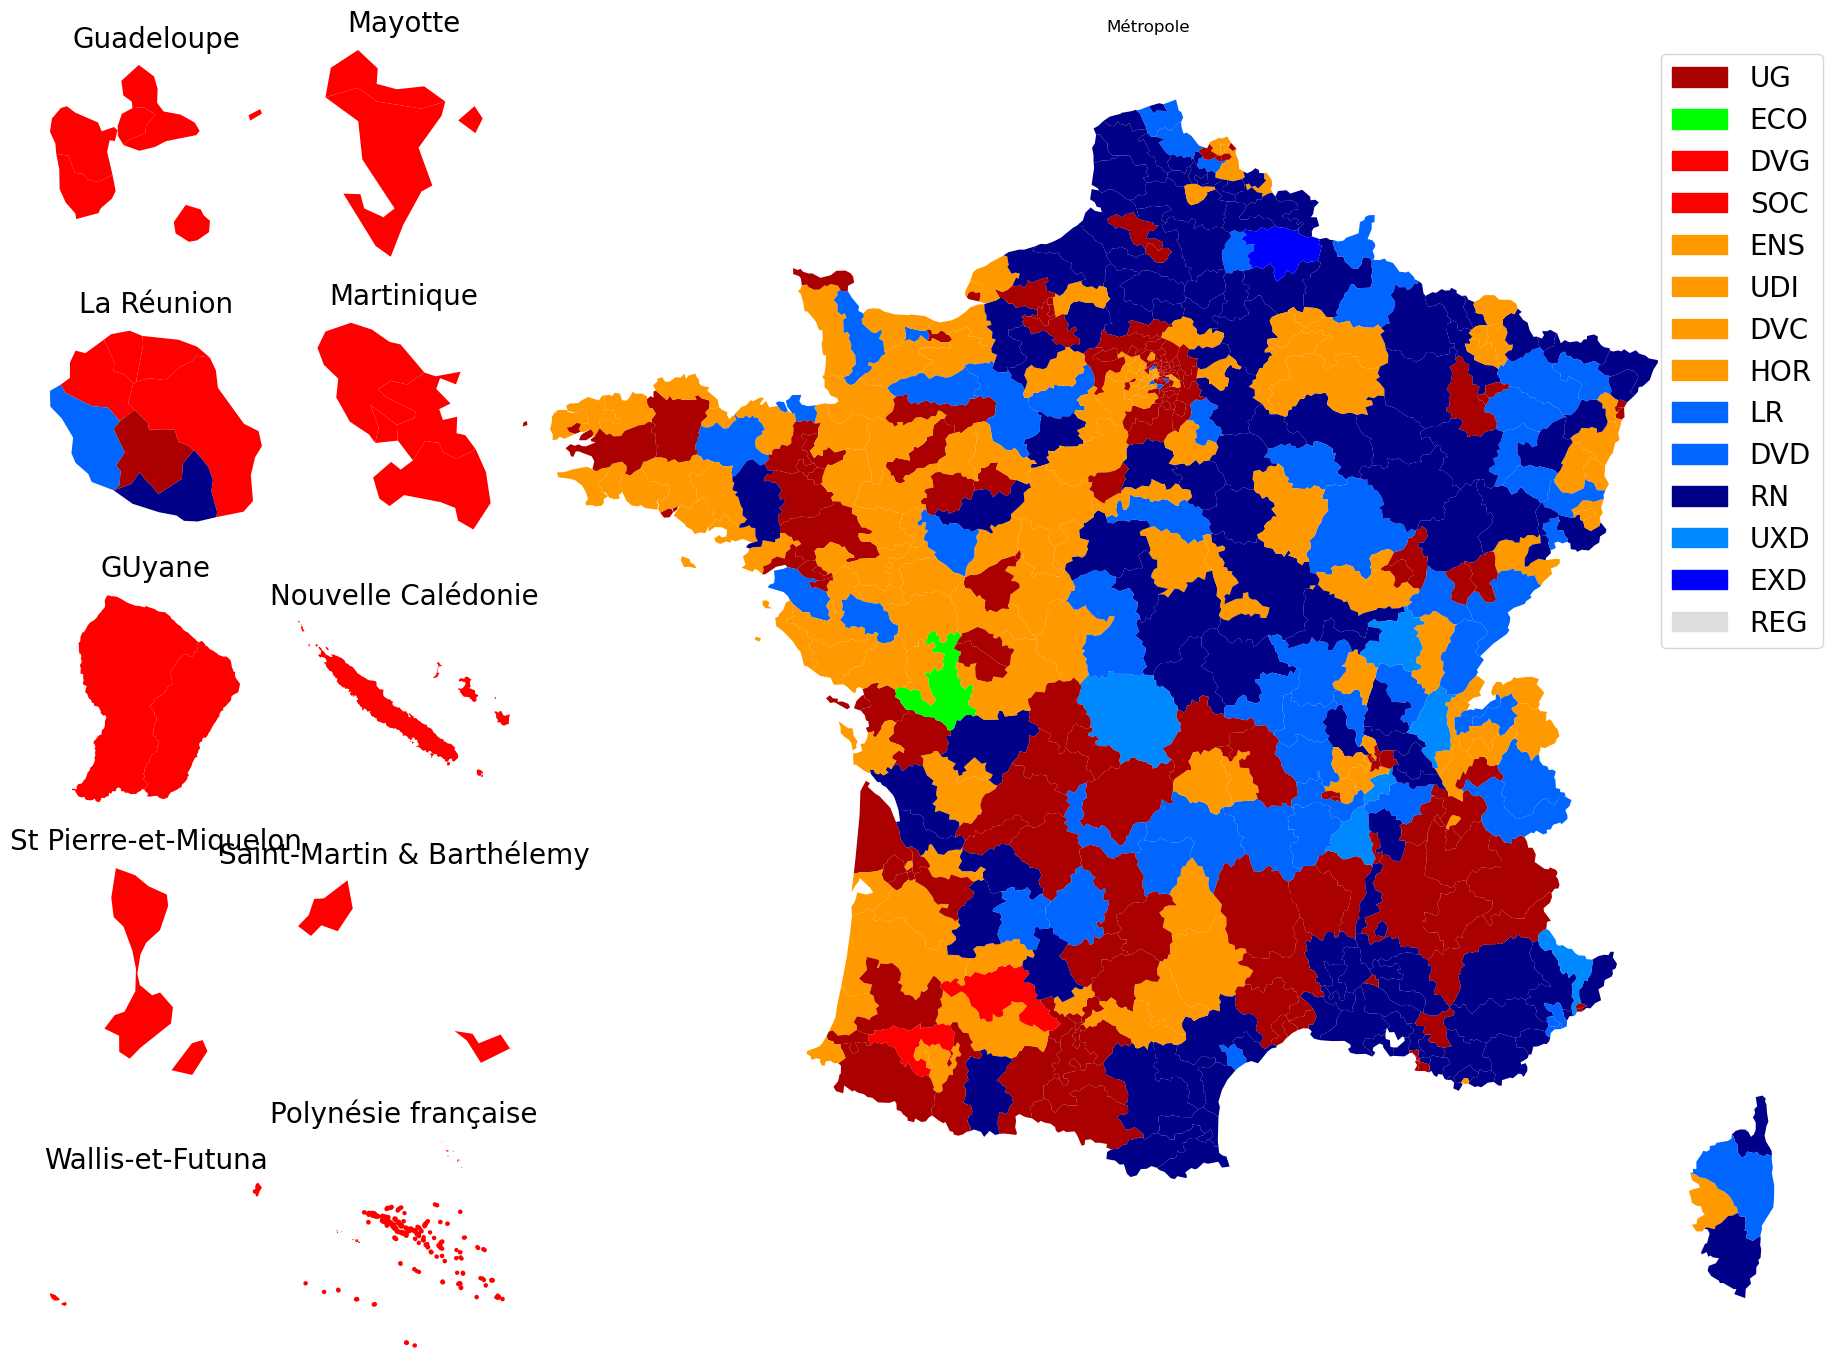

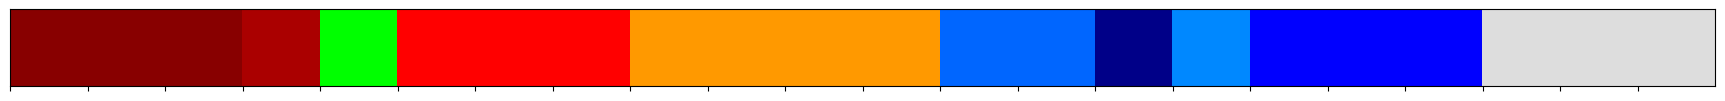

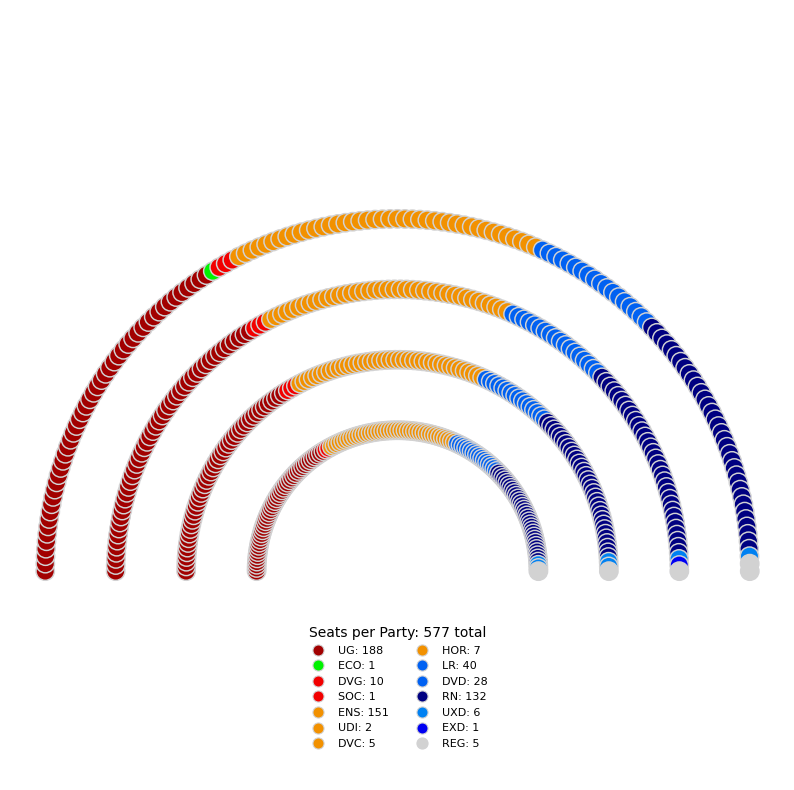

In [130]:
df_second = second_tour_candidats_optimized(df, alliances)
df_second_post = second_tour(df, df_second, alliances, matrice_report, index_report)
compute_winner(df_second_post)
plot_map_france(df_second_post, gdf)
print_assemblee(df_second_post["Winner"].value_counts())